# Deep Learning for MIR

Deep Learning continuously emerges into the **Music Information Retrieval (MIR)** and audio retrieval domain. Besides a general introduction to neural networks, this **tutorial** covers a wide range of MIR relevant deep learning approaches. *Convolutional Neural Networks* are currently a standard for deep learning based audio retrieval. *Recurrent Neural Networks* have proven to be effective in onset detection tasks such as beat or audio-event detection. *Siamese Networks* have shown to be effective in learning audio representations and distance functions specific for music similarity retrieval. 

We introduce these different neural network layer types and architectures on the basis of standard MIR tasks such as *music classification*, *similarity estimation* and *onset detection*.

## GTZAN Music Speech Dataset

The dataset was collected for the purposes of music/speech discrimination. The dataset consists of 128 tracks, each 30 seconds long. Each class (music/speech) has 64 examples. The tracks are all 22050Hz Mono 16-bit audio files in .wav format.

### How to do it...

1. Download and extract the dataset on `DATASET_PATH`. 

In [1]:
DATASET_PATH = '../../../Machine-Learning/music_speech/music_speech'

2. Import all the required packages:

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import progressbar
import IPython
import librosa
import librosa.display

3. Prepare metadata (form a panda dataframe):

In [3]:
MUSIC_DIR = '%s/music_wav' % DATASET_PATH
SPEECH_DIR = '%s/speech_wav' % DATASET_PATH

In [4]:
music_files = glob.glob(os.path.join(MUSIC_DIR,'*.wav'))
speech_files = glob.glob(os.path.join(SPEECH_DIR,'*.wav'))

metadata_music = pd.DataFrame({'filename':music_files, 'label':['music' for f in range(len(music_files))]})
metadata_speech = pd.DataFrame({'filename':speech_files, 'label':['speech' for f in range(len(speech_files))]})

metadata = pd.concat([metadata_music, metadata_speech], axis=0, ignore_index=True)

In [5]:
#head of the dataframe
metadata.head()

,filename,label
0,../../../Machine-Learning/music_speech/music_s...,music
1,../../../Machine-Learning/music_speech/music_s...,music
2,../../../Machine-Learning/music_speech/music_s...,music
3,../../../Machine-Learning/music_speech/music_s...,music
4,../../../Machine-Learning/music_speech/music_s...,music


In [6]:
#tail of the dataframe
metadata.tail()

,filename,label
123,../../../Machine-Learning/music_speech/music_s...,speech
124,../../../Machine-Learning/music_speech/music_s...,speech
125,../../../Machine-Learning/music_speech/music_s...,speech
126,../../../Machine-Learning/music_speech/music_s...,speech
127,../../../Machine-Learning/music_speech/music_s...,speech


## Processing Audio

Load an audio file:

In [7]:
y, sample_rate = librosa.load(metadata.iloc[0].filename, mono=True, sr=None)

Visualize the audio file:

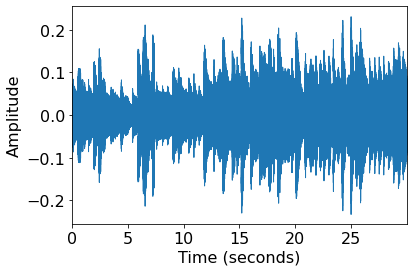

In [22]:
librosa.display.waveplot(y, sr=sample_rate)
plt.xlabel('Time (seconds)',fontsize=16)
plt.ylabel('Amplitude',fontsize=16)
plt.tick_params(axis='both',which='major',labelsize=16)

In [23]:
IPython.display.Audio(metadata.iloc[0].filename)

Compute STFT and show *spectrogram*:

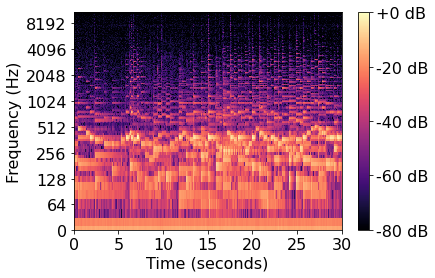

In [24]:
spectrogram = librosa.stft(y, n_fft=1024, hop_length=512)
librosa.display.specshow(np.abs(spectrogram), y_axis='log', x_axis='time', sr=sample_rate)
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
librosa.display.specshow(spectrogram_db, sr=sample_rate, y_axis='linear', x_axis='time')
plt.xlabel('Time (seconds)',fontsize=16)
plt.ylabel('Frequency (Hz)',fontsize=16)
cb = plt.colorbar(format='%+2.0f dB')
cb.ax.tick_params(labelsize=16)
plt.tick_params(axis='both',which='major',labelsize=16)

Show *Mel-spectrogram*:

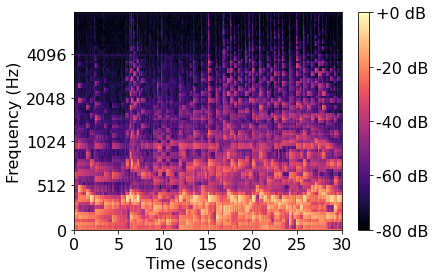

In [29]:
power_spectrogram = np.abs(spectrogram)**2
melspec = librosa.feature.melspectrogram(S=power_spectrogram, n_mels=80, fmax=8000)
melspec_db = librosa.power_to_db(melspec, ref=np.max)
librosa.display.specshow(melspec_db, y_axis='mel', fmax=8000, x_axis='time')
plt.xlabel('Time (seconds)',fontsize=16)
plt.ylabel('Frequency (Hz)',fontsize=16)
cb = plt.colorbar(format='%+2.0f dB')
cb.ax.tick_params(labelsize=16)
plt.tick_params(axis='both',which='major',labelsize=16)

In [30]:
melspec_db.shape

(80, 1292)

## Extract Features

Define feature extraction function:

In [53]:
def load_mel_spec(filename, n_mels=40, n_frames=80, n_fft=512, hop_length=256):
    
    #load audio data
    y, sample_rate = librosa.load(filename, mono=True)
        
    #calculate mel-frequency spectrogram coefficients
    S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, fmax=8000)
    
    #convert to Decibel
    S = librosa.power_to_db(S, ref=np.max)
    print(S.shape)
    
    #take a sample from --> extrae franja vertical central de ancho n_frames
    center_frame_idx = S.shape[1]/2
    offset = int(center_frame_idx-n_frames/2)
    S_redu = S[:,offset:(offset+n_frames)]
    print(S_redu.shape)
    
    return S_redu

Process dataset:

In [56]:
mel_spectrogram_segments = []
pbar = progressbar.ProgressBar()

for filename in pbar(metadata.filename):
    print(filename.split('/')[6], filename.split('/')[7])
    mel_spec = load_mel_spec(filename)
    mel_spectrogram_segments.append(mel_spec)

  7% (10 of 128) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02

music_wav guitar.wav
(40, 2584)
(40, 80)
music_wav loreena.wav
(40, 2584)
(40, 80)
music_wav deedee1.wav
(40, 2584)
(40, 80)
music_wav classical.wav
(40, 2584)
(40, 80)
music_wav gravity.wav
(40, 2584)
(40, 80)
music_wav echoes.wav
(40, 2584)
(40, 80)
music_wav brahms.wav
(40, 2584)
(40, 80)
music_wav bartok.wav
(40, 2584)
(40, 80)
music_wav opera.wav
(40, 2584)
(40, 80)
music_wav copland2.wav
(40, 2584)
(40, 80)
music_wav duke.wav


 15% (20 of 128) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02

(40, 2584)
(40, 80)
music_wav led.wav
(40, 2584)
(40, 80)
music_wav blues.wav
(40, 2584)
(40, 80)
music_wav vlobos.wav
(40, 2584)
(40, 80)
music_wav georose.wav
(40, 2584)
(40, 80)
music_wav eguitar.wav
(40, 2584)
(40, 80)
music_wav beatles.wav
(40, 2584)
(40, 80)
music_wav bigband.wav
(40, 2584)
(40, 80)
music_wav moanin.wav
(40, 2584)
(40, 80)
music_wav prodigy.wav
(40, 2584)
(40, 80)
music_wav u2.wav
(40, 2584)
(40, 80)
music_wav gismonti.wav


 23% (30 of 128) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01

(40, 2584)
(40, 80)
music_wav redhot.wav
(40, 2584)
(40, 80)
music_wav madradeus.wav
(40, 2584)
(40, 80)
music_wav glass.wav
(40, 2584)
(40, 80)
music_wav ncherry.wav
(40, 2584)
(40, 80)
music_wav hendrix.wav
(40, 2584)
(40, 80)
music_wav canonaki.wav
(40, 2584)
(40, 80)
music_wav narch.wav
(40, 2584)
(40, 80)
music_wav opera1.wav
(40, 2584)
(40, 80)
music_wav caravan.wav
(40, 2584)
(40, 80)
music_wav corea1.wav
(40, 2584)
(40, 80)
music_wav cure.wav


 33% (43 of 128) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:01

(40, 2584)
(40, 80)
music_wav gravity2.wav
(40, 2584)
(40, 80)
music_wav ipanema.wav
(40, 2584)
(40, 80)
music_wav marlene.wav
(40, 2584)
(40, 80)
music_wav birdland.wav
(40, 2584)
(40, 80)
music_wav pop.wav
(40, 2584)
(40, 80)
music_wav unpoco.wav
(40, 2584)
(40, 80)
music_wav jazz1.wav
(40, 2584)
(40, 80)
music_wav debussy.wav
(40, 2584)
(40, 80)
music_wav rock2.wav
(40, 2584)
(40, 80)
music_wav bagpipe.wav
(40, 2584)
(40, 80)
music_wav corea.wav


 40% (52 of 128) |#########              | Elapsed Time: 0:00:01 ETA:   0:00:01

(40, 2584)
(40, 80)
music_wav classical1.wav
(40, 2584)
(40, 80)
music_wav march.wav
(40, 2584)
(40, 80)
music_wav mingus.wav
(40, 2584)
(40, 80)
music_wav mingus1.wav
(40, 2584)
(40, 80)
music_wav jazz.wav
(40, 2584)
(40, 80)
music_wav misirlou.wav
(40, 2584)
(40, 80)
music_wav rock.wav
(40, 2584)
(40, 80)
music_wav russo.wav
(40, 2584)
(40, 80)
music_wav bmarsalis.wav
(40, 2584)
(40, 80)
music_wav copland.wav
(40, 2584)
(40, 80)
music_wav beat.wav


 50% (65 of 128) |###########            | Elapsed Time: 0:00:01 ETA:   0:00:01

(40, 2584)
(40, 80)
music_wav chaka.wav
(40, 2584)
(40, 80)
music_wav winds.wav
(40, 2584)
(40, 80)
music_wav deedee.wav
(40, 2584)
(40, 80)
music_wav ballad.wav
(40, 2584)
(40, 80)
music_wav nearhou.wav
(40, 2584)
(40, 80)
music_wav magkas.wav
(40, 2584)
(40, 80)
music_wav classical2.wav
(40, 2584)
(40, 80)
music_wav glass1.wav
(40, 2584)
(40, 80)
music_wav tony.wav
(40, 2584)
(40, 80)
speech_wav psychic.wav
(40, 2584)
(40, 80)
speech_wav kid.wav


 58% (75 of 128) |#############          | Elapsed Time: 0:00:01 ETA:   0:00:01

(40, 2584)
(40, 80)
speech_wav jvoice.wav
(40, 2584)
(40, 80)
speech_wav relation.wav
(40, 2584)
(40, 80)
speech_wav greek1.wav
(40, 2584)
(40, 80)
speech_wav undergrad.wav
(40, 2584)
(40, 80)
speech_wav ellhnika.wav
(40, 2584)
(40, 80)
speech_wav pulp.wav
(40, 2584)
(40, 80)
speech_wav pulp2.wav
(40, 2584)
(40, 80)
speech_wav danie1.wav
(40, 2584)
(40, 80)
speech_wav smoke1.wav
(40, 2584)
(40, 80)
speech_wav thlui.wav
(40, 2584)
(40, 80)
speech_wav teachers2.wav


 64% (82 of 128) |##############         | Elapsed Time: 0:00:01 ETA:   0:00:00

(40, 2584)
(40, 80)
speech_wav fem_rock.wav
(40, 2584)
(40, 80)
speech_wav smoking.wav
(40, 2584)
(40, 80)
speech_wav vegetables1.wav
(40, 2584)
(40, 80)
speech_wav acomic2.wav
(40, 2584)
(40, 80)
speech_wav comedy1.wav
(40, 2584)
(40, 80)
speech_wav austria.wav
(40, 2584)
(40, 80)
speech_wav dialogue2.wav
(40, 2584)
(40, 80)
speech_wav vegetables.wav


 73% (94 of 128) |################       | Elapsed Time: 0:00:01 ETA:   0:00:00

(40, 2584)
(40, 80)
speech_wav shannon.wav
(40, 2584)
(40, 80)
speech_wav kedar.wav
(40, 2584)
(40, 80)
speech_wav nj105.wav
(40, 2584)
(40, 80)
speech_wav diamond.wav
(40, 2584)
(40, 80)
speech_wav georg.wav
(40, 2584)
(40, 80)
speech_wav serbian.wav
(40, 2584)
(40, 80)
speech_wav female.wav
(40, 2584)
(40, 80)
speech_wav china.wav
(40, 2584)
(40, 80)
speech_wav nether.wav
(40, 2584)
(40, 80)
speech_wav geography1.wav


 81% (104 of 128) |#################     | Elapsed Time: 0:00:02 ETA:   0:00:00

(40, 2584)
(40, 80)
speech_wav chant.wav
(40, 2584)
(40, 80)
speech_wav comedy.wav
(40, 2584)
(40, 80)
speech_wav india.wav
(40, 2584)
(40, 80)
speech_wav acomic.wav
(40, 2584)
(40, 80)
speech_wav male.wav
(40, 2584)
(40, 80)
speech_wav news2.wav
(40, 2584)
(40, 80)
speech_wav allison.wav
(40, 2584)
(40, 80)
speech_wav danie.wav
(40, 2584)
(40, 80)
speech_wav dialogue.wav
(40, 2584)
(40, 80)
speech_wav teachers1.wav


 86% (111 of 128) |###################   | Elapsed Time: 0:00:02 ETA:   0:00:00

(40, 2584)
(40, 80)
speech_wav fire.wav
(40, 2584)
(40, 80)
speech_wav sleep.wav
(40, 2584)
(40, 80)
speech_wav vegetables2.wav
(40, 2584)
(40, 80)
speech_wav news1.wav
(40, 2584)
(40, 80)
speech_wav conversion.wav
(40, 2584)
(40, 80)
speech_wav my_voice.wav
(40, 2584)
(40, 80)
speech_wav jony.wav
(40, 2584)
(40, 80)
speech_wav greek.wav


 93% (120 of 128) |####################  | Elapsed Time: 0:00:02 ETA:   0:00:00

(40, 2584)
(40, 80)
speech_wav charles.wav
(40, 2584)
(40, 80)
speech_wav god.wav
(40, 2584)
(40, 80)
speech_wav pulp1.wav
(40, 2584)
(40, 80)
speech_wav geography.wav
(40, 2584)
(40, 80)
speech_wav teachers.wav
(40, 2584)
(40, 80)
speech_wav oneday.wav
(40, 2584)
(40, 80)
speech_wav stupid.wav
(40, 2584)
(40, 80)
speech_wav lena.wav
(40, 2584)
(40, 80)
speech_wav bathroom1.wav
(40, 2584)
(40, 80)
speech_wav nj105a.wav


100% (128 of 128) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


(40, 2584)
(40, 80)
speech_wav emil.wav
(40, 2584)
(40, 80)
speech_wav amal.wav
(40, 2584)
(40, 80)
speech_wav voices.wav
(40, 2584)
(40, 80)
speech_wav voice.wav
(40, 2584)
(40, 80)
speech_wav dialogue1.wav
(40, 2584)
(40, 80)


In [57]:
#convert result list to numpy array
mel_spectrogram_segments = np.asarray(mel_spectrogram_segments)    
mel_spectrogram_segments.shape

(128, 40, 80)

Store dataset:

In [58]:
np.savez('%s/mel_spectrogram_segments' % DATASET_PATH,
         data = mel_spectrogram_segments,
         filenames = metadata.filename)

In [1]:
from IPython.core.display import HTML
css_file = '../.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())